In [60]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from category_encoders import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

In [61]:

# 데이터 불러오기
df = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/feature_target.csv')  # 데이터셋 파일 경로 지정

# 데이터 탐색 및 전처리
df.drop(columns = ['first_join_date','gender'], inplace =True)
df.loc[:,'low'] = df.loc[:,'low'].astype('float32')
df.loc[:,'high'] = df.loc[:,'high'].astype('float32')
df.loc[:,'book_cnt'] = df.loc[:,'book_cnt'].astype('Int32')
df.loc[:,'time/event'] = df.loc[:,'time/event'].astype('float32')
df.loc[:,'add_book_mean'] = df.loc[:,'add_book_mean'].astype('float32')
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()
df.loc[:,'session_cnt'] = df.loc[:,'session_cnt'].astype('Int32')
df.loc[:,'average_revenue'] = df.loc[:,'average_revenue'].astype('float64')
df.loc[:, 'RFM_Segment'] = df.loc[:, 'RFM_Segment'].astype(str).astype('category')
df.loc[:, 'home_location'] = df.loc[:, 'home_location'].astype('category')
df.loc[:, 'age_segment'] = df.loc[:, 'age_segment'].astype('category')
df.loc[:, 'RFM_Segment'] = df.loc[:, 'RFM_Segment'].astype('category')


In [62]:
df = df.drop_duplicates()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50699 entries, 0 to 50698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   customer_id      50699 non-null  int64   
 1   home_location    50699 non-null  object  
 2   age_segment      50699 non-null  object  
 3   RFM_Segment      50699 non-null  category
 4   low              50699 non-null  float64 
 5   high             50699 non-null  float64 
 6   book_cnt         50699 non-null  int64   
 7   time/event       50699 non-null  float64 
 8   add_book_mean    50699 non-null  float64 
 9   revisit          50699 non-null  float64 
 10  session_cnt      50699 non-null  int64   
 11  add_cnt          50699 non-null  float64 
 12  promo_use        50699 non-null  int64   
 13  average_revenue  50699 non-null  int64   
 14  bounce           50699 non-null  int64   
dtypes: category(1), float64(6), int64(6), object(2)
memory usage: 5.5+ MB


In [64]:
#수치형 특성 추출
df_num = df.dtypes[(df.dtypes != "object") & (df.dtypes != "category")].index
df[df_num]


,customer_id,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_cnt,promo_use,average_revenue,bounce
0,7279,0.135593,0.067797,89,104.576805,1.666933,6.157089e+04,989,59.0,18,47868665,1
1,82542,1.000000,0.000000,1,108.299011,0.002844,0.000000e+00,1,0.0,0,115702,1
2,96453,0.000000,0.000000,2,260.637573,2.797282,8.842406e+05,11,4.0,1,380724,1
3,8031,0.500000,0.250000,3,311.722778,5.752834,3.793925e+06,17,4.0,3,2312833,1
4,9152,0.333333,0.000000,3,261.235138,24.356647,4.050262e+06,15,5.0,2,491337,1
...,...,...,...,...,...,...,...,...,...,...,...,...
50694,38690,0.142857,0.142857,6,287.877563,41.054657,3.550305e+06,38,8.0,3,3409814,1
50695,34743,0.133333,0.200000,37,141.346207,3.708100,9.602015e+04,584,20.0,12,15903689,1
50696,72065,0.075472,0.075472,44,223.700867,5.943343,3.813352e+05,381,86.0,13,30918201,1
50697,32818,0.089172,0.133758,96,124.382912,2.872606,9.673476e+04,1273,78.0,36,56652588,1


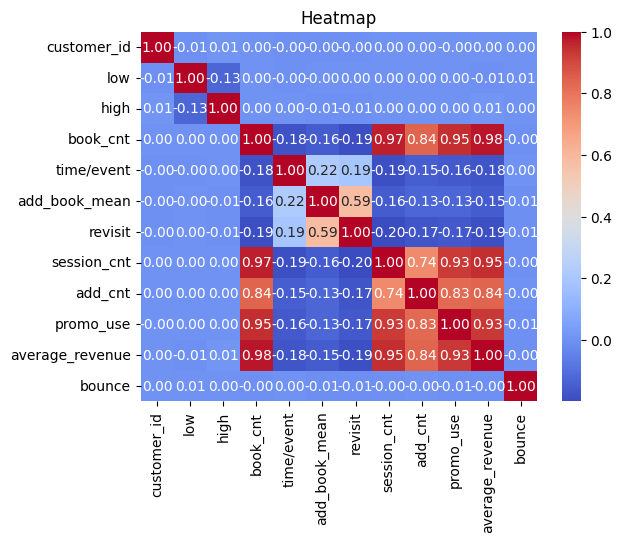

In [65]:
# 수치형 특성 간 상관계수 히트맵
sns.heatmap(df[df_num].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Heatmap")
plt.show()


# 클래스 불균형

In [66]:
# baseline 정확도 0.82548
df['bounce'].value_counts(normalize =True)

bounce
1    0.82548
0    0.17452
Name: proportion, dtype: float64

# 다운 샘플링

In [67]:
# downsample_factor = 2

# downsampled_data  = df[df['bounce'] == 1].groupby(df[df['bounce'] == 1].index // downsample_factor).first()

In [68]:


# # 특성과 목표 변수 분리
# X = pd.concat([downsampled_data, df[df['bounce'] == 0]]).drop(columns=['bounce'], axis=1)
# y = pd.concat([downsampled_data, df[df['bounce'] == 0]])['bounce']




In [69]:
X = df.drop(columns= ['bounce'])
y = df['bounce']

# base모델

In [82]:
df_num = df_num.drop('bounce')

In [84]:

# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# One-Hot encoding
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)


# 특성 스케일링: 표준화

scaler = StandardScaler()
X_train_ohe[df_num] = scaler.fit_transform(X_train_ohe[df_num])
X_test_ohe[df_num] = scaler.transform(X_test_ohe[df_num])


# 로지스틱 회귀 모델 생성
logreg = LogisticRegression(class_weight = {1: len(df[df['bounce'] == 1])/len(df)})

In [85]:
#학습
logreg.fit(X_train_ohe, y_train)

#확률 예측  
base_train_pred = logreg.predict(X_train_ohe)
base_test_prob = logreg.predict_proba(X_test_ohe)[:,-1]

#임계점 설정
threshold = 0.625
base_test_pred = (base_test_prob > threshold).astype(int)

#스코어 확인
classification_rep = classification_report(y_test, base_test_pred, zero_division=1)
print(classification_rep)
accuracy_score(y_test, base_test_pred)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1770
           1       0.83      1.00      0.90      8370

    accuracy                           0.83     10140
   macro avg       0.91      0.50      0.45     10140
weighted avg       0.86      0.83      0.75     10140



c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8254437869822485

In [86]:
print(classification_report(y_train, base_train_pred))
print(classification_report(y_test, base_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7078
           1       0.83      1.00      0.90     33481

    accuracy                           0.83     40559
   macro avg       0.41      0.50      0.45     40559
weighted avg       0.68      0.83      0.75     40559

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1770
           1       0.83      1.00      0.90      8370

    accuracy                           0.83     10140
   macro avg       0.41      0.50      0.45     10140
weighted avg       0.68      0.83      0.75     10140



c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hm981\anaconda3\env

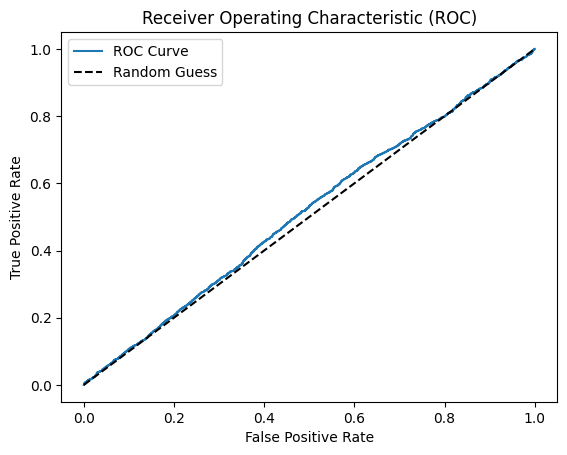

ROC AUC: 0.5136881787929719


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_log_proba(X_test_ohe)[:,1])

# ROC 곡선 그리기
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


roc_auc = roc_auc_score(y_test, logreg.predict_log_proba(X_test_ohe)[:,1])
print('ROC AUC:', roc_auc)

# grid search smote()

In [88]:

# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# One-Hot encoding
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

# 특성 스케일링: 표준화

scaler = StandardScaler()
X_train_ohe[df_num] = scaler.fit_transform(X_train_ohe[df_num])
X_test_ohe[df_num] = scaler.transform(X_test_ohe[df_num])

# 로지스틱 회귀 모델 생성
logreg2 = LogisticRegression()

In [89]:
def threshold_range(start, end, step):
    thresholds = np.arange(start, end, step)
    return thresholds.tolist()

# GridSearchCV에 사용할 매개변수 그리드 정의
thresholds = threshold_range(0.45, 0.55, 0.005)

In [90]:
param = {'multi_class' : ['ovr'],
        'C' : [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
        'max_iter' : range(500, 1000, 100)
        }

grid_search = GridSearchCV(logreg2, param, cv=5)
grid_search.fit(X_train_ohe, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1],
                         'max_iter': range(500, 1000, 100),
                         'multi_class': ['ovr']})

In [91]:

# 임계값 설정
threshold = 0.5

#훈련 스코어
train_proba = grid_search.predict_proba(X_train_ohe)[:, 1]
train_pred = (train_proba > threshold).astype(int)
train_accuracy = accuracy_score(y_train, train_pred)
print('train=', train_accuracy)

#테스트 스코어
y_proba = grid_search.predict_proba(X_test_ohe)[:, 1]
y_pred = (y_proba > threshold).astype(int)
classification_rep = classification_report(y_test, y_pred, zero_division=1)
print(classification_rep)
accuracy_score(y_test, y_pred)

train= 0.8254887941024187
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1770
           1       0.83      1.00      0.90      8370

    accuracy                           0.83     10140
   macro avg       0.91      0.50      0.45     10140
weighted avg       0.86      0.83      0.75     10140



0.8254437869822485

In [92]:
print("ROC_AUC_score", roc_auc_score(y_test, y_pred))

ROC_AUC_score 0.5


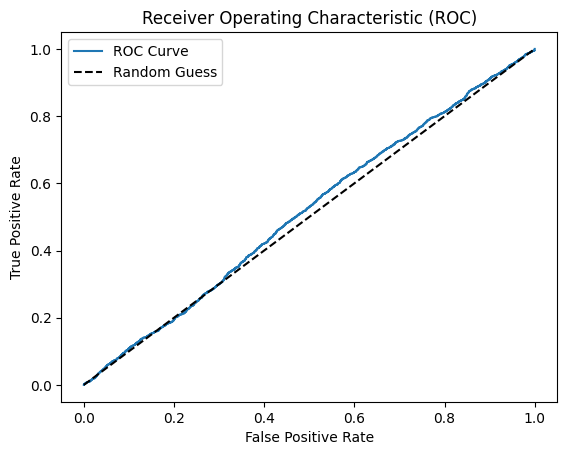

ROC AUC: 0.5147136328966109


In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# ROC 곡선 그리기
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


roc_auc = roc_auc_score(y_test, y_proba)
print('ROC AUC:', roc_auc)

In [94]:
import pandas as pd
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
import numpy as np

import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

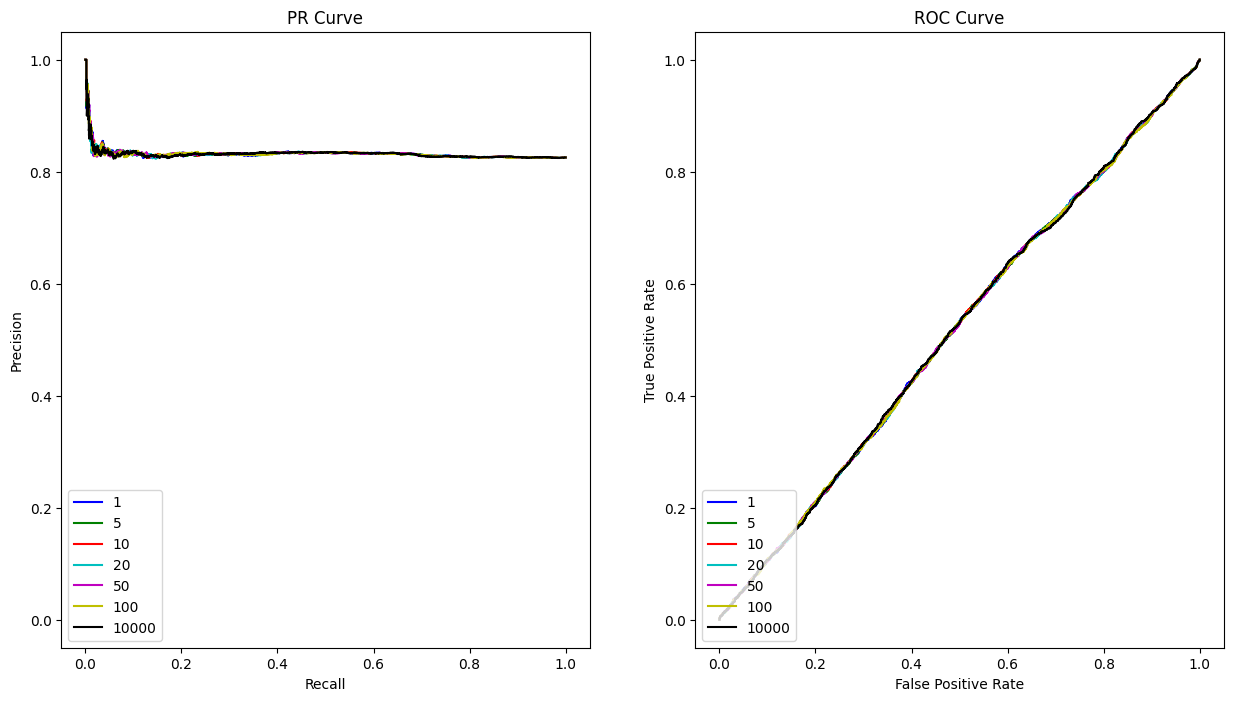

In [95]:
#PRECISION - RECALL 그래프
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train_ohe,y_train)
    pred_prob = lr_model.predict_proba(X_test_ohe)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

In [96]:
best_model = grid_search.best_estimator_
feature_importance = best_model.coef_[0]


# 결과 출력
feature_set = pd.DataFrame()
ls1 = []
ls2 = []
for feature, importance in zip(X_train_ohe.columns, feature_importance):
    ls1.append(feature)
    ls2.append(importance)

In [97]:
best_model.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [98]:
feature_set['feature'] = ls1
feature_set['importance'] = ls2

In [99]:
feature_set['abs'] = [abs(x) for x in ls2]

In [100]:
feature_set.sort_values('abs', ascending =False)

,feature,importance,abs
4,home_location_4,0.108193,0.108193
24,home_location_24,-0.092516,0.092516
40,RFM_Segment_1,-0.078088,0.078088
20,home_location_20,0.075825,0.075825
1,home_location_1,-0.072700,0.072700
...,...,...,...
49,RFM_Segment_10,-0.003988,0.003988
7,home_location_7,-0.002870,0.002870
36,age_segment_3,0.000905,0.000905
51,RFM_Segment_12,-0.000891,0.000891


# grid search svmsmote() 오버샘플링

In [101]:
from imblearn.over_sampling import SVMSMOTE


# 특성과 목표 변수 분리
X = df.drop(columns=['bounce'], axis=1)
y = df['bounce']

# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# One-Hot encoding
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

# SMOTE 적용
svmsmote = SVMSMOTE(sampling_strategy=1.0, random_state=42)
X_train_svm, y_train_svm = svmsmote.fit_resample(X_train_ohe, y_train)

# 특성 스케일링: 표준화

scaler = StandardScaler()
X_train_svm[df_num] = scaler.fit_transform(X_train_svm[df_num])
X_test_ohe[df_num] = scaler.transform(X_test_ohe[df_num])


# 로지스틱 회귀 모델 생성
logreg3 = LogisticRegression(class_weight = {1: len(df[df['bounce'] == 0]) / len(df[df['bounce'] == 1])})

In [102]:
param = {'multi_class' : ['ovr'],
        'C' : [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
        'max_iter' : range(500, 1000, 100)
        }

grid_search2 = GridSearchCV(logreg3, param, cv=5)
grid_search2.fit(X_train_svm, y_train_svm)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={1: 0.2114166925521493}),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1],
                         'max_iter': range(500, 1000, 100),
                         'multi_class': ['ovr']})

In [103]:
best_model2 = grid_search2.best_estimator_
best_model2.get_params()

{'C': 0.1,
 'class_weight': {1: 0.2114166925521493},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [104]:

# 임계값 설정
threshold = 0.5

#훈련 스코어
train_proba = grid_search2.predict_proba(X_train_svm)[:, 1]
train_pred = (train_proba > threshold).astype(int)
train_accuracy = accuracy_score(y_train_svm, train_pred)
print('train=', train_accuracy)


#테스트 스코어
y_proba = grid_search2.predict_proba(X_test_ohe)[:, 1]
y_pred = (y_proba > threshold).astype(int)
classification_rep = classification_report(y_test, y_pred, zero_division=1)
print(classification_rep)
accuracy_score(y_test, y_pred)

train= 0.5361100325557779
              precision    recall  f1-score   support

           0       0.18      0.92      0.29      1770
           1       0.84      0.09      0.16      8370

    accuracy                           0.23     10140
   macro avg       0.51      0.50      0.23     10140
weighted avg       0.72      0.23      0.18     10140



0.23353057199211044

c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

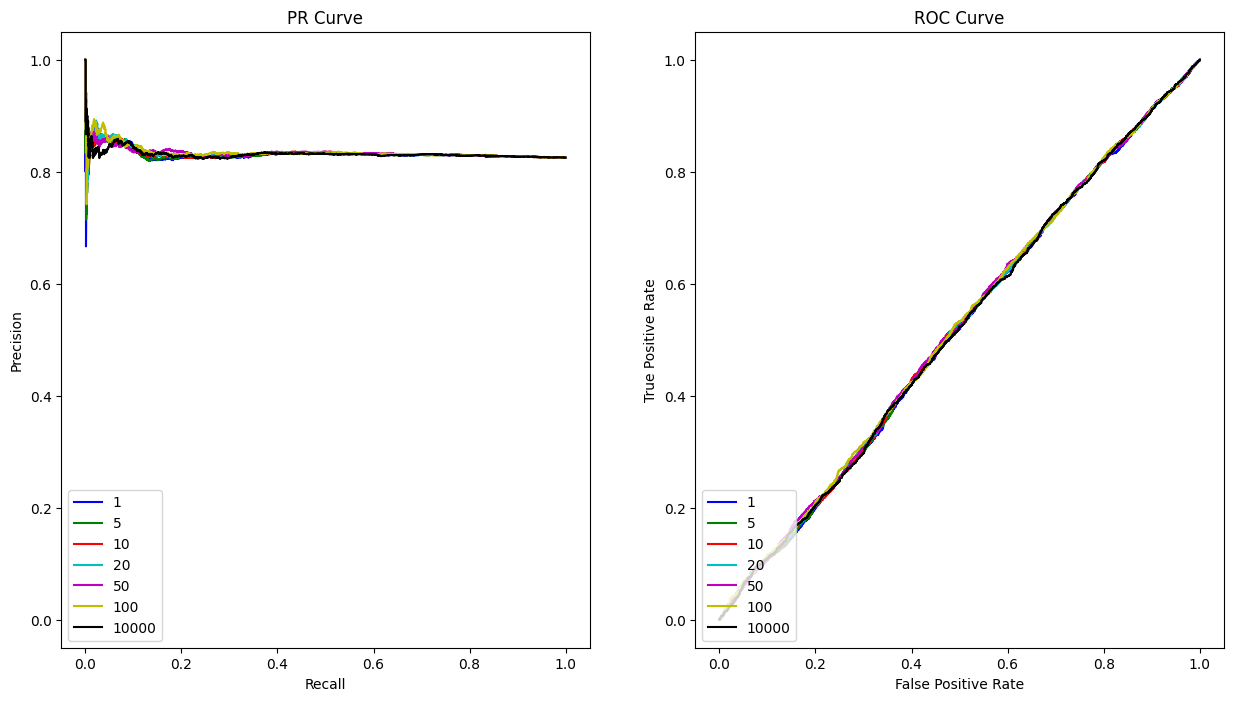

In [105]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train_svm,y_train_svm)
    pred_prob = lr_model.predict_proba(X_test_ohe)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()